### The primary point of this notebook is to convert the 2-minute photometry to SQLite.
It takes a few minutes to generate the database, but it makes later queries ~1000x faster!
#### The secondary point of this notebook is to explain the structure and nature of the data.

In [1]:
%pylab
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import os

In [3]:
from gPhoton.MCUtils import angularSeparation, print_inline
from gPhoton.galextools import counts2mag, mag2counts

In [4]:
import sqlalchemy as sql #create_engine

In [5]:
import dask.dataframe as dd

In [6]:
photdir = '../photom'

#### Use GJ65 (aka UV Ceti) as the test source.

In [19]:
skypos = (24.76279, -17.94948) # position of UV Ceti
match_radius = 0.005
eclipse = 26980 # This is one of the UV Ceti eclipses

#### Analyze a test visit (e26980).
To understand the structure of the data.

In [20]:
photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv' # This is one of the UV Ceti eclipses
fn = photfile.split('/')[-1]
exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
phot = pd.read_csv(photfile)
expt = pd.read_csv(exptfile)
total_expt = expt.expt.sum()
print(f'Eclipse {eclipse} summary:')
print(f'   * {round(total_expt)} seconds of exposure')
print(f'   * {len(phot)} unique sources detected')
print(f'   * {len(phot.loc[phot.aperture_sum_mask==0])} unflagged sources')

Eclipse 26980 summary:
   * 1063 seconds of exposure
   * 1795 unique sources detected
   * 1728 unflagged sources


#### Demonstrate that the flagging is meaningful

RA range  ==> [208.38, 209.62]
Dec range ==> [4.39, 5.64]


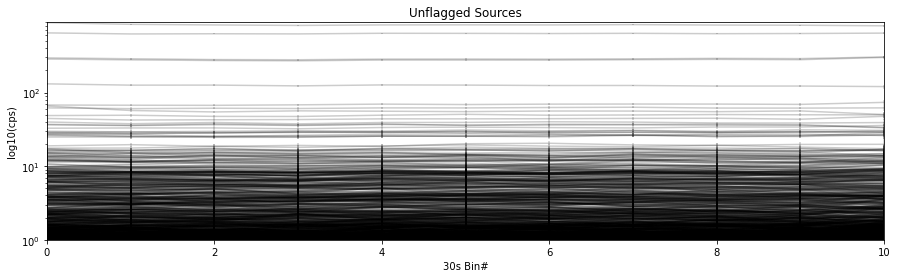

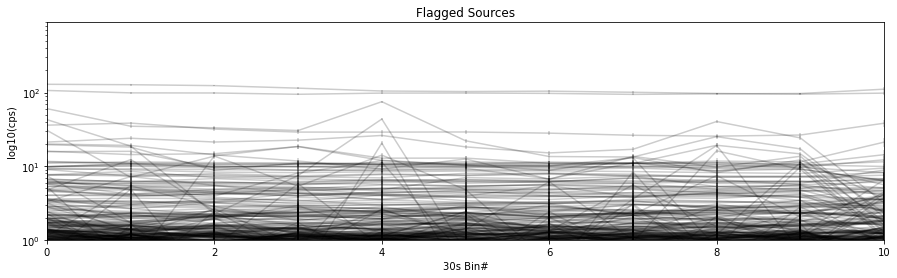

In [9]:
plt.figure(figsize=(15,4))
plt.title('Unflagged Sources')
for index in phot.index.values:
    if ((phot.loc[index].aperture_sum_mask!=0) |
        (phot.loc[index].aperture_sum_edge!=0)):
        continue
    cnt = phot.loc[index][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
plt.semilogy()
plt.xlabel('30s Bin#')
plt.ylabel('log10(cps)')
plt.xlim([0,10])
plt.ylim([1,900])

plt.figure(figsize=(15,4))
plt.title('Flagged Sources')
for index in phot.index.values:
    if not ((phot.loc[index].aperture_sum_mask!=0) |
        (phot.loc[index].aperture_sum_edge!=0)):
        continue
    cnt = phot.loc[index][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
plt.semilogy()
plt.xlabel('30s Bin#')
plt.ylabel('log10(cps)')
plt.xlim([0,10])
plt.ylim([1,900])

print(f"RA range  ==> [{np.round(phot.ra.min(),2)}, {np.round(phot.ra.max(),2)}]")
print(f"Dec range ==> [{np.round(phot.dec.min(),2)}, {np.round(phot.dec.max(),2)}]")

#### Dump the source position into an SQLite database.
This provides a >1000x speed up over using Dask.

In [10]:
def populate_sqlite(regen=False,catdbfile = 'catalog.db',photdir = '../photom'):
    if os.path.exists(catdbfile) and not regen:
        print(f'{catdbfile} already exists.')
        return
    if os.path.exists(catdbfile) and regen:
        os.remove(catdbfile)
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    n_sources = 0
    for i,edir in enumerate(os.listdir(photdir)):
        if 'DS_Store' in edir: # Skip the annoying OSX cruft
            continue
        for csvfile in os.listdir(f'{photdir}/{edir}/'):
            if 'nd-photom' in csvfile:
                photpath = f'{photdir}/{edir}/{csvfile}'
                expt = pd.read_csv(photpath.replace('-photom','-exptime'))
                total_exptime = expt.expt.sum()
                eclipse = int(csvfile.split('-')[0][1:])
                photpath = f'{photdir}/{edir}/{csvfile}'
                phot = pd.read_csv(photpath)
                #print(total_exptime,phot.aperture_sum.values)
                n_sources += len(phot)
                phot['eclipse'] = eclipse
                pos = phot[['eclipse', 'id', 'ra', 'dec', 'xcenter', 'ycenter']]
                pos['exptime'] = total_exptime
                pos['cps'] = np.array(phot.aperture_sum.values)/total_exptime
                pos['cps_err'] = np.sqrt(phot.aperture_sum.values)/total_exptime
                pos['hasmask'] = phot.aperture_sum_mask.values!=0
                pos['hasedge'] = phot.aperture_sum_edge.values!=0
                #pos.to_csv(photpath.replace('-photom','-pos'),index=False)
                pos.to_sql('gfcat', con=engine, if_exists='append' if i!=0 else 'replace')
        if not i%100:
            print_inline(f'Ingesting: {i}')
    # Index on RA, Dec --- this is what we're most interested in searching against
    engine.execute("CREATE INDEX 'ix_gfcat' ON 'gfcat' ('ra', 'dec')")
    engine.dispose()
    print_inline('Source position data dumped to SQLite.\n')
    return

%time populate_sqlite()

catalog.db already exists.
CPU times: user 46 µs, sys: 38 µs, total: 84 µs
Wall time: 71 µs


In [11]:
# Test that the database is complete.
def gfcat_count(catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(f"SELECT COUNT(eclipse) FROM gfcat ").fetchall()
    engine.dispose()
    return out[0][0]

%time assert(gfcat_count()==18340721) # This is how many sources should be in the database

CPU times: user 784 ms, sys: 323 ms, total: 1.11 s
Wall time: 1.11 s


#### Implement a cone search

In [12]:
def query(query,catdbfile='catalog.db'):
    # This will just run any SQL query that you feed it
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(query).fetchall()
    engine.dispose()
    return out

%time brightstars = query(f"SELECT eclipse, id FROM gfcat WHERE hasmask=0 AND hasedge=0 AND cps>622") # 2x the 10% rolloff
print(f'There are {len(brightstars)} very bright stars.\n')

CPU times: user 1.51 s, sys: 326 ms, total: 1.83 s
Wall time: 1.83 s
There are 2795 very bright stars.



In [13]:
def conesearch(skypos,match_radius=0.005,catdbfile='catalog.db'):
    # This runs a box search in SQLite and then refines it into a cone
    out = np.array(query(f"SELECT eclipse, id, ra, dec, xcenter, ycenter FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}"))
    dist_ix = np.where(angularSeparation(skypos[0],skypos[1],
                                         out[:,2],out[:,3])<=match_radius)
    return pd.DataFrame({'eclipse':np.array(out[:,0][dist_ix],dtype='int16'),
                         'id':np.array(out[:,1][dist_ix],dtype='int16'),
                         'ra':out[:,2][dist_ix],
                         'dec':out[:,3][dist_ix],
                         'xcenter':out[:,4][dist_ix],
                         'ycenter':out[:,5][dist_ix]})

%time uvceti = conesearch((24.76279, -17.94948)) # UV Ceti
print(f'There are {len(uvceti)} UV Ceti observations.')

CPU times: user 3.01 ms, sys: 1.64 ms, total: 4.65 ms
Wall time: 3.1 ms
There are 9 UV Ceti observations.


#### Define functions to get and plot lightcurves given a source position

In [46]:
# Modify this function to use sqlite...
def get_lightcurves(skypos,match_radius=0.005,debug=False,catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = np.array(engine.execute(f"SELECT eclipse, id, ra, dec FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}").fetchall())
    engine.dispose()
    pos = pd.DataFrame({'eclipse':out[:,0],'id':out[:,1],
                        'ra':out[:,2],'dec':out[:,3]})    #pos = df[angularSeparation(skypos[0],skypos[1],df.ra,df.dec)<match_radius][['eclipse','id','ra','dec']].compute()
    pos['dist'] = angularSeparation(skypos[0],skypos[1],pos.ra.values,pos.dec.values)
    if debug:
        plt.figure(figsize=(5,5))
        plt.title(f'{len(pos)} sources found')
        plt.plot(pos.ra,pos.dec,'k.',alpha=0.7)
        plt.plot(skypos[0],skypos[1],'rx')
        plt.xlim([skypos[0]-max(pos.dist.values)*1.1,skypos[0]+max(pos.dist.values)*1.1])
        plt.ylim([skypos[1]-max(pos.dist.values)*1.1,skypos[1]+max(pos.dist.values)*1.1])
        plt.xticks([])
        plt.yticks([])
    data = {}
    total_expt = 0
    for j in np.arange(len(pos)):
        eclipse = int(pos.iloc[j].eclipse)
        photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv'
        exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
        phot = pd.read_csv(photfile)
        expt = pd.read_csv(exptfile)
        total_expt += expt.expt.sum()
        cnt = phot.iloc[j][
                ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
            ].values
        cps = cnt / expt.expt.values.flatten()
        cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
        if debug:
            plt.figure(figsize=(15,3))
            plt.title(f'{j} : e{eclipse} : {int(pos.iloc[j].id)} : {pos.iloc[j].dist}')
            plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
            plt.ylabel('cps')
            plt.xticks([])
        data[j] = {'eclipse':eclipse,
                   'id':pos.iloc[j].id,
                   't0':expt.t0.min(),
                   't1':expt.t1.max(),
                   'photfile':photfile,
                   'exptfile':exptfile,
                   'photdata':phot,
                   'exptdata':expt,
                   'counts':cnt,
                   'cps':cps,
                   'cps_err':cps_err}
    print(f'Returning {int(total_expt)} seconds of exposure.')
    return data

%time data = get_lightcurves((24.76279, -17.94948))
print(f'\nEach visit has an index (n={len(data.keys())}):\n{data.keys()}')
print(f'\nVisit #0:\n{data[0].keys()}')
print(f'\teclipse: e{data[0]["eclipse"]}')
print(f'\tsource#: {(id:=int(data[0]["id"]))}')
print(f'\nPhotometry #0:\n{data[0]["photdata"].keys()}')
print(f'\nWe will need the pixel coordinates for the next notebook:')
print(f'\t({int(data[0]["photdata"].iloc[id-1].xcenter)}, {int(data[0]["photdata"].iloc[id-1].ycenter)})')
#                                          ^^ Because Pandas indexes from 1               ^^
#                                          ^^ Whereas numpy indexes from 0                ^^

Returning 13520 seconds of exposure.
CPU times: user 116 ms, sys: 13.2 ms, total: 129 ms
Wall time: 128 ms

Each visit has an index (n=9):
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

Visit #0:
dict_keys(['eclipse', 'id', 't0', 't1', 'photfile', 'exptfile', 'photdata', 'exptdata', 'counts', 'cps', 'cps_err'])
	eclipse: e13656
	source#: 804

Photometry #0:
Index(['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2',
       'npix', 'sky', 'peak', 'flux', 'mag', 'xcenter', 'ycenter',
       'aperture_sum', 'aperture_sum_mask', 'aperture_sum_edge', 'ra', 'dec',
       'aperture_sum_0', 'aperture_sum_1', 'aperture_sum_2', 'aperture_sum_3',
       'aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6', 'aperture_sum_7',
       'aperture_sum_8', 'aperture_sum_9', 'aperture_sum_10',
       'aperture_sum_11', 'aperture_sum_12', 'aperture_sum_13',
       'aperture_sum_14'],
      dtype='object')

We will need the pixel coordinates for the next notebook:
	(1475, 1647)


#### Define functions to return photometry data given an eclipse / source index

CPU times: user 29.4 ms, sys: 2.82 ms, total: 32.3 ms
Wall time: 30.9 ms


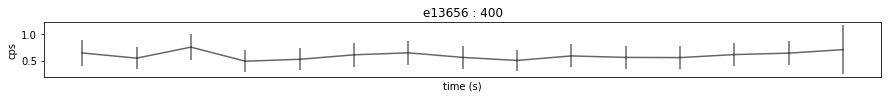

In [15]:
def get_lightcurve(eclipse,ix,photdir = '../photom'):
    # given an eclipse and source id, return the lightcurve data
    phot = pd.read_csv(f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv')
    expt = pd.read_csv(f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv')
    total_expt = expt.expt.sum()
    cnt = np.array(phot.iloc[ix][
        ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
            ].values)
    exptimes = expt.expt.values,
    cps = cnt / exptimes
    cps_err = np.sqrt(cnt) / exptimes
    return pd.DataFrame({'t0':expt.t0,'t1':expt.t1,
                         'expt':exptimes[0],'counts':cnt,
                         'cps':(cnt / exptimes[0]),
                         'cps_err':(np.sqrt(cnt) / exptimes[0])})

def plot_lightcurve(eclipse,ix,photdir = '../photom',title=''):
    # given an eclipse and source id, plot the lightcurve
    lc = get_lightcurve(eclipse,ix,photdir=photdir)
    plt.figure(figsize=(15,1))
    plt.title(title if title else f'e{eclipse} : {ix}')
    plt.errorbar(np.array(lc['t0'])-min(lc['t0']),lc['cps'],yerr=lc['cps_err']*3,fmt='k-',alpha=0.6)
    plt.xlabel('time (s)')
    plt.ylabel('cps')
    plt.xticks([])
    return

%time plot_lightcurve(13656,400,photdir = '../photom')